# Análisis de Sentimiento de Reseñas de Gift Cards de Amazon

Desarrollar una aplicación de línea de comandos en Python que realice análisis de sentimientos en reseñas de productos. Este proyecto permitirá a los estudiantes aplicar herramientas y técnicas aprendidas en el curso, desde la preparación del entorno hasta el procesamiento de datos y la documentación del proyecto.

# 1. Importación de Librerías Necesarias

In [1]:
# Importar las librerías necesarias
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import pipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import BertTokenizer, BertForSequenceClassification

C:\Users\jeshu\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


# 2. Descarga de Recursos de NLTK

In [2]:
# Descargar los recursos necesarios de NLTK
nltk.download('vader_lexicon')
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jeshu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jeshu\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\jeshu\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jeshu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jeshu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# 3. Carga de Datos desde el Archivo JSONL

In [3]:
# Obtener la ruta del directorio actual del notebook y construir la ruta al archivo JSONL 
ruta_jsonl = Path.cwd() / 'data' / 'Gift_Cards_reviews.jsonl'
# Cargar los datos usando pandas
try:
    df = pd.read_json(ruta_jsonl, lines = True, encoding = 'utf-8')
    print(f"Datos cargados correctamente desde '{nombre_archivo}'.")
except FileNotFoundError:
    print(f"El archivo '{nombre_archivo}' no se encontró. Asegúrate de que esté en el directorio correcto.")
except ValueError as e:
    print(f"Error al leer el archivo JSONL: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Ocurrió un error inesperado: name 'nombre_archivo' is not defined


In [4]:
# Mostrar las primeras filas del DataFrame
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Great gift,Having Amazon money is always good.,[],B00IX1I3G6,B00IX1I3G6,AHZ6XMOLEWA67S3TX7IWEXXGWSOA,2019-02-11 06:22:38.332,0,True
1,5,amazon gift card,Always the perfect gift. I have never given o...,[],B005ESMMWW,B005ESMMWW,AFZUK3MTBIBEDQOPAK3OATUOUKLA,2020-09-12 01:45:58.120,0,False
2,5,perfect gift,When you have a person who is hard to shop for...,[],B01K8RIM5Y,B005S28ZES,AFZUK3MTBIBEDQOPAK3OATUOUKLA,2018-09-03 01:58:49.239,27,True
3,5,Nice looking,The tin is a nice touch and pretty large. It'...,[],B0091JKVU0,B00ADR2LV6,AFZUK3MTBIBEDQOPAK3OATUOUKLA,2014-12-13 02:59:37.000,0,False
4,1,Not $10 Gift Cards,I bought this pack of Starbucks Gift cards in ...,[],B00FTGTM5E,B00FTGTIOE,AH5L7ILVA6HYLZOUZIQAWNHVVK3A,2021-11-28 03:06:48.115,2,True


# 4. Exploración Inicial de los Datos

In [5]:
# Información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             100 non-null    int64         
 1   title              100 non-null    object        
 2   text               100 non-null    object        
 3   images             100 non-null    object        
 4   asin               100 non-null    object        
 5   parent_asin        100 non-null    object        
 6   user_id            100 non-null    object        
 7   timestamp          100 non-null    datetime64[ns]
 8   helpful_vote       100 non-null    int64         
 9   verified_purchase  100 non-null    bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 7.3+ KB


El DataFrame analizado consta de $100$ registros y $10$ columnas, cada una con diferentes tipos de datos que permiten una variada manipulación y análisis.

## 4.1 Análisis Estadístico de los Datos

In [6]:
# Análisis descriptivo de las columnas numéricas
print("Análisis Estadístico de las Calificaciones:")
df.describe()

Análisis Estadístico de las Calificaciones:


,rating,timestamp,helpful_vote
count,100.000000,100,100.00000
mean,4.750000,2020-02-20 04:19:59.610149888,0.67000
min,1.000000,2014-12-13 02:59:37,0.00000
25%,5.000000,2018-12-21 17:50:23.657750016,0.00000
50%,5.000000,2020-07-17 14:21:46.125500160,0.00000
75%,5.000000,2021-11-25 16:16:41.659749888,0.00000
max,5.000000,2023-02-17 03:33:52.230000,27.00000
std,0.880484,NaN,3.28466


Entre las columnas, se destacan dos de tipo entero (`int64`): 

- `rating`, que representa la calificación otorgada con valores que van desde $1$ hasta $5$ y una media elevada de $4.75$, indicando una tendencia hacia calificaciones positivas.
- `helpful_vote`, que cuenta con un rango de $0$ a $27$ votos útiles, con una media de $0.67$ y una desviación estándar de $3.28$, lo que sugiere una dispersión moderada en la cantidad de votos útiles recibidos. 

La columna `timestamp` es de tipo `datetime64[ns]`, abarcando un periodo desde el $13$ de diciembre de $2014$ hasta el $17$ de febrero de $2023$, con una media que se sitúa en el $20$ de febrero de $2020$, lo que permite realizar análisis temporales detallados. 

Además, la presencia de una columna booleana (`bool`) denominada `verified_purchase` indica si la compra fue verificada, lo que puede ser crucial para filtrar opiniones auténticas.
 
Las demás columnas son de tipo objeto (`object`):

- `title` y `text`, que probablemente contienen el título y el contenido de las reseñas, respectivamente, lo que permite realizar análisis de texto y extracción de información relevante.
- `asin` y `parent_asin` identifican los productos y sus variantes parentales, facilitando la categorización y el seguimiento de productos específicos dentro del dataset. 
- `user_id` almacena identificadores únicos de los usuarios, lo que posibilita el análisis de comportamiento y patrones de interacción de los usuarios con los productos. 

La estructura del DataFrame, con todas las columnas no nulas, garantiza la integridad de los datos, permitiendo realizar análisis confiables sin la necesidad de manejar valores faltantes. En conjunto, este DataFrame ofrece una base sólida para realizar análisis estadísticos, de comportamiento del consumidor y de sentimiento, aprovechando la diversidad y calidad de los datos disponibles.

## 4.2 Análisis Gráfico de los Datos

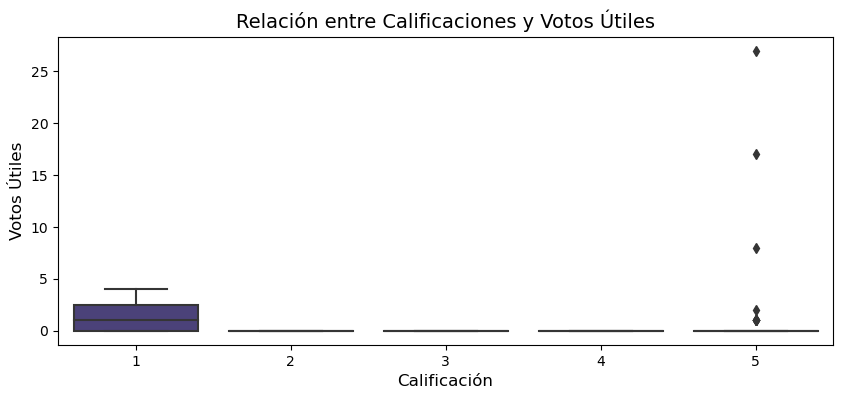

In [7]:
# Relación entre Calificaciones y Votos Útiles
plt.figure(figsize = (10, 4))
sns.boxplot(x = 'rating', y = 'helpful_vote', data = df, palette = 'viridis')
plt.title('Relación entre Calificaciones y Votos Útiles', fontsize = 14)
plt.xlabel('Calificación', fontsize = 12)
plt.ylabel('Votos Útiles', fontsize = 12)
plt.show()

# 5. Preprocesamiento de Texto

## 5.1. Normalización de Textos

In [8]:
# Función para normalizar el texto
def normalizar_texto(texto):
    """
    Normaliza el texto convirtiéndolo a minúsculas y eliminando puntuación.
    
    Parámetros:
    texto (str): Texto a normalizar.
    
    Retorna:
    str: Texto normalizado.
    """
    return texto.lower().translate(str.maketrans('', '', string.punctuation))

In [9]:
# Aplicar la normalización al texto
df['texto_normalizado'] = df['text'].apply(normalizar_texto)

## 5.2. Tokenización

In [10]:
# Función para tokenizar el texto
def tokenizar_texto(texto):
    """
    Tokeniza el texto en palabras individuales.
    
    Parámetros:
    texto (str): Texto a tokenizar.
    
    Retorna:
    list: Lista de tokens.
    """
    return word_tokenize(texto)

In [11]:
# Aplicar la tokenización al texto normalizado
df['tokens'] = df['texto_normalizado'].apply(tokenizar_texto)

## 5.3. Eliminación de Stop Words

In [12]:
# Función para eliminar stop words
def eliminar_stopwords(tokens):
    """
    Elimina las stop words de una lista de tokens.
    
    Parámetros:
    tokens (list): Lista de tokens.
    
    Retorna:
    list: Lista de tokens sin stop words.
    """
    return [word for word in tokens if word not in set(stopwords.words('english'))]

In [13]:
# Aplicar la eliminación de stop words
df['tokens_sin_stopwords'] = df['tokens'].apply(eliminar_stopwords)

## 5.4. Lematización

In [14]:
# Función para lematizar tokens
def lematizar_tokens(tokens):
    """
    Lematiza una lista de tokens.
    
    Parámetros:
    tokens (list): Lista de tokens.
    
    Retorna:
    list: Lista de tokens lematizados.
    """
    return [WordNetLemmatizer().lemmatize(word) for word in tokens]

In [15]:
# Aplicar la lematización
df['tokens_lemmatizados'] = df['tokens_sin_stopwords'].apply(lematizar_tokens)

## 5.5. Etiquetado Gramatical

In [16]:
# Función para etiquetar gramaticalmente los tokens
def etiquetar_gramaticalmente(tokens):
    """
    Etiqueta gramaticalmente una lista de tokens.
    
    Parámetros:
    tokens (list): Lista de tokens.
    
    Retorna:
    list: Lista de tuplas con el token y su etiqueta gramatical.
    """
    return nltk.pos_tag(tokens)

In [17]:
# Aplicar el etiquetado gramatical
df['etiquetas_gramaticales'] = df['tokens_lemmatizados'].apply(etiquetar_gramaticalmente)

# 6. Análisis de Sentimientos con el Modelo Preentrenado BERT

In [18]:
# Función para analizar sentimiento
def analizar_sentimiento(texto, modelo = 'nlptown/bert-base-multilingual-uncased-sentiment', max_length = 512, device = -1):
    """
    Analiza el sentimiento de un texto utilizando un modelo BERT preentrenado.

    Parámetros:
    texto (str): El texto de la reseña a analizar.
    modelo (str): El nombre del modelo BERT preentrenado. Por defecto, 'bert-base-uncased'.
    max_length (int): La longitud máxima del tokenizado. Por defecto, 512.
    device (int): El dispositivo a utilizar (-1 para CPU, >=0 para GPU). Por defecto, -1.

    Retorna:
    dict: Un diccionario con la etiqueta del sentimiento y la puntuación.
    """
    tokenizer    = BertTokenizer.from_pretrained(modelo)
    model        = BertForSequenceClassification.from_pretrained(modelo)
    clasificador = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)
    resultado    = clasificador(texto, truncation = True, max_length = max_length)[0]
    return resultado

In [19]:
# Aplicar la función de análisis de sentimiento a cada reseña
df['resultado_sentimiento'] = df['text'].apply(analizar_sentimiento)

# Separar la etiqueta y la puntuación en columnas distintas
df['etiqueta_sentimiento'] = df['resultado_sentimiento'].apply(lambda x: x['label'])
df['puntaje_sentimiento']  = df['resultado_sentimiento'].apply(lambda x: x['score'])

C:\Users\jeshu\Anaconda\Lib\site-packages\transformers\modeling_utils.py:479: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=m

# 7. Clasificación de Sentimiento en Categorías

In [20]:
# Función para clasificar el sentimiento
def clasificar_sentimiento(puntaje):
    """
    Clasifica el puntaje de sentimiento en categorías: Insatisfecho, Neutral, Satisfecho.
    
    Parámetros:
    puntaje (float): Puntaje de sentimiento.
    
    Retorna:
    str: Categoría de sentimiento.
    """
    if 0 < puntaje <= 0.3:
        return 'Insatisfecho'
    elif 0.3 < puntaje <= 0.5:
        return 'Neutral'
    elif puntaje > 0.5:
        return 'Satisfecho'
    else:
        return 'No definido'

In [21]:
# Aplicar la clasificación de sentimiento
df['categoria_sentimiento'] = df['puntaje_sentimiento'].apply(clasificar_sentimiento)

# 8. Visualización de Sentimientos

## 8.1. Gráficas de Barras Comparativas

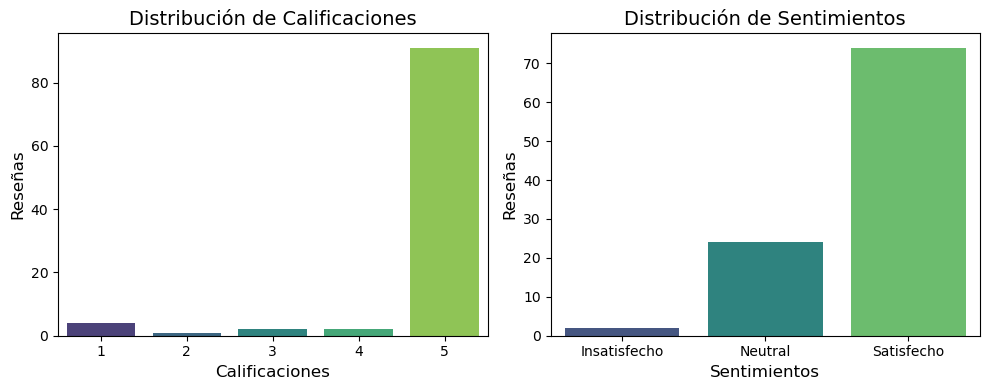

In [22]:
# Crear una figura con dos subplots (una fila, dos columnas)
fig, axes = plt.subplots(1, 2, figsize = (10, 4))
# Distribución de Calificaciones
sns.countplot(x = 'rating', data = df, palette = 'viridis', order = sorted(df['rating'].unique()), ax = axes[0])
axes[0].set_title('Distribución de Calificaciones', fontsize = 14)
axes[0].set_xlabel('Calificaciones', fontsize = 12)
axes[0].set_ylabel('Reseñas', fontsize = 12)
axes[0].tick_params(axis = 'x', rotation = 0)  
# Distribución de Sentimientos
sns.countplot(x = 'categoria_sentimiento', data = df, palette = 'viridis', order = ['Insatisfecho', 'Neutral', 'Satisfecho'], ax = axes[1])
axes[1].set_title('Distribución de Sentimientos', fontsize = 14)
axes[1].set_xlabel('Sentimientos', fontsize = 12)
axes[1].set_ylabel('Reseñas', fontsize = 12)
axes[1].tick_params(axis = 'x', rotation = 0)
plt.tight_layout()
plt.show()

## 8.2 Gráficas de Barras Palabras más Comunes

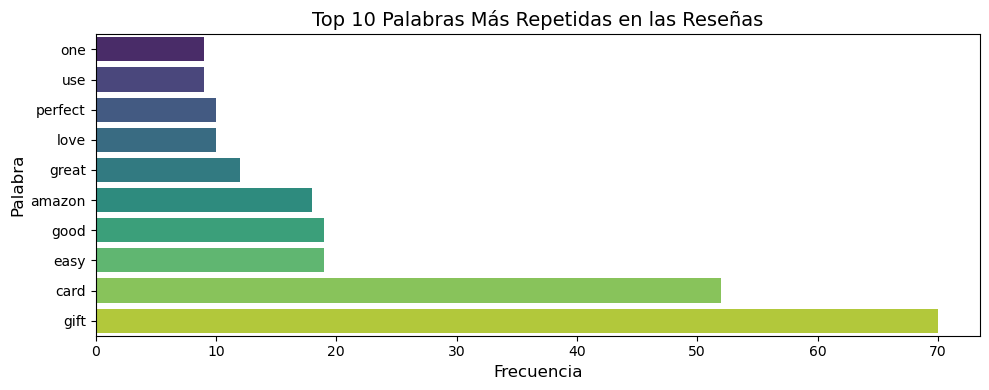

In [23]:
# Diez palabras más comunes
palabras_top = pd.DataFrame(Counter(palabra for tokens in df['tokens_lemmatizados'] for palabra in tokens).most_common(10), 
                            columns = ['Palabra', 'Frecuencia']).sort_values('Frecuencia')
plt.figure(figsize = (10, 4))
sns.barplot(x = 'Frecuencia', y = 'Palabra', data = palabras_top, palette = 'viridis')
plt.title('Top 10 Palabras Más Repetidas en las Reseñas', fontsize = 14)
plt.xlabel('Frecuencia', fontsize = 12)
plt.ylabel('Palabra', fontsize = 12)
plt.tight_layout()
plt.show()

## 8.3. Nube de Palabras de las Reseñas

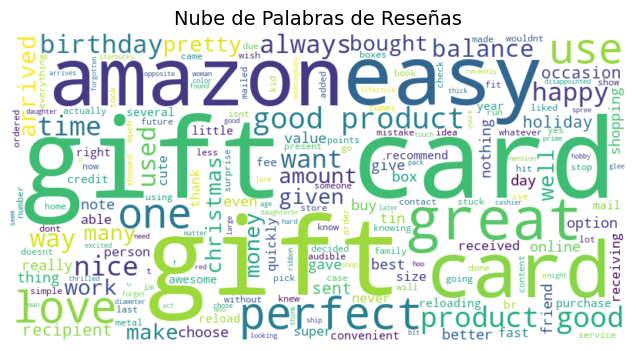

In [24]:
# Generar la nube de palabras
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(' '.join(df['texto_normalizado']))
plt.figure(figsize = (10, 4))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Nube de Palabras de Reseñas', fontsize = 14)
plt.show()